# Customer Segmentation using K-Means Clustering

## Introduction 
In this project, the Recency Frequency, and Monetary values computed from customer transaction data. The RFM values are used to form groups of customers. Un-supervised machine learning algorithm; K-Means clustering was used. 

In [2]:
## necessary imports

import pandas as pd

from datetime import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [3]:
# necessary import for data standardization and machine learning model

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [4]:
# read csv file

customer_data = pd.read_csv('./dataset/online.csv')

## Compute RFM values

In [5]:
customer_data['InvoiceDate'] = pd.to_datetime(customer_data['InvoiceDate'])
customer_data['InvoiceDate'] = customer_data['InvoiceDate'].apply(lambda x: dt(x.year, x.month, x.day))

In [6]:
customer_data['OrderAmt'] = customer_data['Quantity'] * customer_data['UnitPrice']

In [7]:
reference_date = max(customer_data['InvoiceDate']) + timedelta(days=1)

In [8]:
RFM = customer_data.groupby(['CustomerID']).agg({'InvoiceDate' : lambda x : (reference_date-max(x)).days,
                                                 'InvoiceNo' : 'count',
                                                 'OrderAmt' : 'sum'
                                                })

In [9]:
RFM.rename(columns = {'InvoiceDate':'Recency',
                  'InvoiceNo': 'Frequency',
                  'OrderAmt':'Monetary'}, inplace=True)

In [10]:
RFM.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747,3,27,992.82
12748,1,967,7522.06
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


## Data Preprocessing for K-Means
1. skew data require Log transformation
2. K-means require data to have mean=0 and standard deviation=1; we used standard scaler 

In [11]:
# data pre-processing

RFM_log = np.log(RFM)
scaler = StandardScaler()
scaler.fit(RFM)
RFM_normalized = scaler.transform(RFM)
print('mean: ', RFM_normalized.mean(axis=0).round(2))
print('std: ', RFM_normalized.std(axis=0).round(2))

mean:  [-0.  0.  0.]
std:  [1. 1. 1.]


## K-means clustering to obtain optimal clusters

In [12]:
# n_clusters = 3 obtained using elbow method 

kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(RFM_normalized)
cluster_labels = kmeans.labels_

In [13]:
RFM = RFM.assign(Cluster = cluster_labels)

In [14]:
RFM.groupby(['Cluster']).agg({
'Recency': 'mean',
'Frequency': 'mean',
'Monetary': ['mean', 'count'],
}).round(0)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          23.0     394.0  16485.0    15
1          42.0      22.0    388.0  2723
2         245.0       6.0    109.0   963

### Observations
1. Cluster 0 has the highest monetary value, this include loyal customers
2. Cluster 1 has lower recency in comparison to cluster 2
3. Cluster 2 has lowest monetary value, the customers might have churned since recency is 245 on average. 

### Comparing clusters using snake plot

In [15]:
RFM_normalized = pd.DataFrame(RFM_normalized,
index=RFM.index,
columns=RFM.columns[:-1])
RFM_normalized['Cluster'] = RFM['Cluster']

In [16]:
datamart_melt = pd.melt(RFM_normalized.reset_index(),
id_vars=['CustomerID', 'Cluster'],
value_vars=['Recency', 'Frequency', 'Monetary'],
var_name='Attribute',
value_name='Value')

<AxesSubplot:title={'center':'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

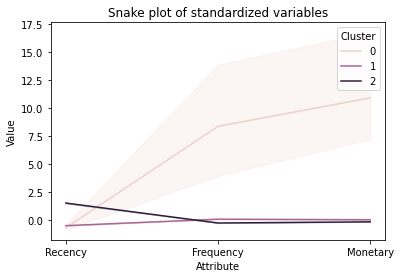

In [17]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=datamart_melt)